In [20]:
from helper_loader import *
from histalign.backend.registration import (
    get_transformation_matrix_from_q_transform,
    recreate_q_transform_from_alignment,
)

In [2]:
alignment_path = Path(
    "/home/ediun/git/histalign/projects/project_cortical_depth/9f5d5f117d/7b067a31b027506e3b39b5679a5151f9.json"
)
alignment_settings = load_alignment_settings(alignment_path)

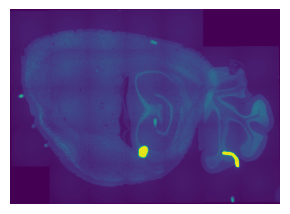

In [3]:
image = load_image(alignment_settings.histology_path)
imshow(image[::10, ::10], figsize=(3, 3))

In [4]:
cortex_mask = load_structure_mask(
    "Isocortex", alignment_settings.volume_settings.resolution, return_raw_array=True
)

structure_name = "Primary motor area, Layer 1"
cortical_structure_mask = load_structure_mask(
    structure_name,
    alignment_settings.volume_settings.resolution,
    return_raw_array=True,
)

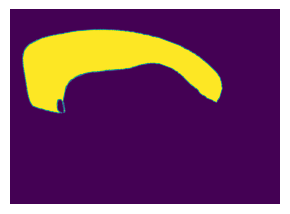

In [5]:
cortex_slice = VolumeSlicer(volume=vedo.Volume(cortex_mask)).slice(
    alignment_settings.volume_settings
)
cortex_slice = Registrator(True, True).get_reversed_image(
    alignment_settings, "Isocortex", image
)
imshow(cortex_slice[::10, ::10], figsize=(3, 3))

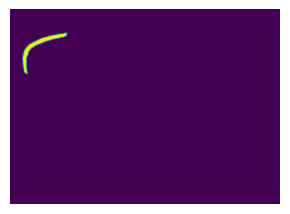

In [6]:
cortical_structure_slice = VolumeSlicer(
    volume=vedo.Volume(cortical_structure_mask)
).slice(alignment_settings.volume_settings)
cortical_structure_slice = Registrator(True, True).get_reversed_image(
    alignment_settings, structure_name, image
)
imshow(cortical_structure_slice[::10, ::10], figsize=(3, 3))

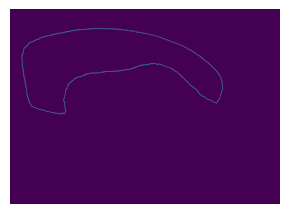

In [7]:
cortex_contours_slice = np.zeros_like(cortex_slice)
draw_contours(find_contours(cortex_slice)[-1:], cortex_contours_slice, width=10)
imshow(cortex_contours_slice[::10, ::10], figsize=(3, 3))

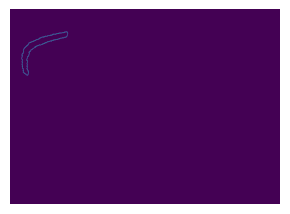

In [8]:
cortical_structure_contours_slice = np.zeros_like(cortical_structure_slice)
draw_contours(
    find_contours(cortical_structure_slice),
    cortical_structure_contours_slice,
    width=10,
)
imshow(cortical_structure_contours_slice[::10, ::10], figsize=(3, 3))

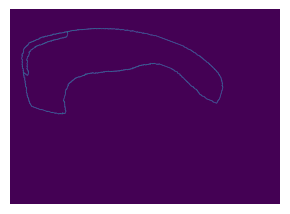

In [9]:
imshow(
    (cortex_contours_slice + cortical_structure_contours_slice)[::10, ::10],
    figsize=(3, 3),
)

In [10]:
# Easier to understand but 3x slower
# def closest_contour_point(point, contour):
#     distances = np.sum((contour - point) ** 2, axis=1)
#     return np.argmin(distances)


def closest_contour_point(point, contour):
    deltas = contour - point
    distances = np.einsum("ij,ij->i", deltas, deltas)
    return np.argmin(distances)

In [13]:
structure_points = np.fliplr(
    np.array(cortical_structure_contours_slice.nonzero()).astype(np.uint16).T
)

cortex_contour = find_contours(cortex_slice)[-1]
contour = cortex_contour.reshape(-1, 2)
closest_cortex_points = [
    contour[closest_contour_point(point, contour)] for point in structure_points
]

In [14]:
# def compute_distances_nonisometric_grid(points, closest_points, x_size, y_size):
#     distances = []
#     for point, closest_point in zip(points, closest_points):
#         x_distance = point[0] - closest_point[0]
#         y_distance = point[1] - closest_point[1]
#
#         distance = np.sqrt((x_distance * x_size) ** 2 + (y_distance * y_size) ** 2)
#         distances.append(distance)
#
#     return distances


def compute_distances_nonisometric_grid(points, closest_points, x_size, y_size):
    return np.array(
        [
            np.sqrt(
                ((point[0] - closest_point[0]) * x_size) ** 2
                + ((point[1] - closest_point[1]) * y_size) ** 2
            )
            for point, closest_point in zip(points, closest_points)
        ]
    )

In [17]:
distances = compute_distances_nonisometric_grid(
    structure_points, closest_cortex_points, 1, 3
)

In [18]:
print(
    f"""
Minimum cortical depth of {structure_name}: {np.min(distances):>7.3f}
Maximum cortical depth of {structure_name}: {np.max(distances):>7.3f}
Average cortical depth of {structure_name}: {np.mean(distances):>7.3f}
Std dev cortical depth of {structure_name}: {np.std(distances):>7.3f}
"""
)


Minimum cortical depth of Primary motor area, Layer 1:   0.000
Maximum cortical depth of Primary motor area, Layer 1: 951.005
Average cortical depth of Primary motor area, Layer 1: 270.287
Std dev cortical depth of Primary motor area, Layer 1: 319.249



In [23]:
get_transformation_matrix_from_q_transform(
    recreate_q_transform_from_alignment(image.shape, alignment_settings, False)
)

array([[ 8.28454000e-01,  2.42549000e-01,  1.30299127e+03],
       [-3.51658000e-01,  9.39950000e-01,  2.23421890e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])